# Описание проекта

Интернет-магазин «Викишоп» запустил новый сервис, где пользователи могут редактировать и дополнять описания товаров. Однако вместе с полезными комментариями могут появляться токсичные сообщения, требующие модерации.

Цель проекта — разработать модель машинного обучения, которая будет автоматически определять токсичные комментарии и отправлять их на проверку.

Для обучения модели предоставлен датасет toxic_comments.csv, содержащий комментарии (text) и метку токсичности (toxic), где 1 — токсичный, 0 — нет.

Задача:
* Подготовить данные и выбрать подходящую модель.
* Достичь F1-score ≥ 0.75.
* Проверить качество классификации на тестовой выборке.

В качестве решения использована модель BERT, позволяющая эффективно анализировать тексты и учитывать контекст слов.

# Предобработка и анализ данных

In [1]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModel
from tqdm import notebook
from tqdm import tqdm
import torch

import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
# Определяем устройство (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv('/datasets/toxic_comments.csv')
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
df = df.drop(columns = ["Unnamed: 0"])
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
df["toxic"].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

Данные несбалансированы:

* 89.8% комментариев нетоксичные (0)
* 10.2% комментариев токсичные (1)

In [7]:
def clean_text(text):
    text = text.lower() # Приведение к нижнему регистру
    text = re.sub(r'\n', ' ', text) # Удаление переводов строк
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) #Удаление спецсимволов
    text = re.sub(r'\s+', ' ', text).strip() #Удаление лишних пробелов
    return text

display(df["text"])

df["text"] = df["text"].apply(clean_text)
display(df["text"])

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159287    ":::::And for the second time of asking, when ...
159288    You should be ashamed of yourself \n\nThat is ...
159289    Spitzer \n\nUmm, theres no actual article for ...
159290    And it looks like it was actually you who put ...
159291    "\nAnd ... I really don't think you understand...
Name: text, Length: 159292, dtype: object

0         explanation why the edits made under my userna...
1         daww he matches this background colour im seem...
2         hey man im really not trying to edit war its j...
3         more i cant make any real suggestions on impro...
4         you sir are my hero any chance you remember wh...
                                ...                        
159287    and for the second time of asking when your vi...
159288    you should be ashamed of yourself that is a ho...
159289    spitzer umm theres no actual article for prost...
159290    and it looks like it was actually you who put ...
159291    and i really dont think you understand i came ...
Name: text, Length: 159292, dtype: object

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Токсичные комментарии,Частота (токсичные),Нетоксичные комментарии,Частота (нетоксичные)
0,fuck,8664,article,53771
1,dont,3877,page,43141
2,like,3759,wikipedia,31969
3,shit,3648,talk,29883
4,wikipedia,3473,please,28533
5,nigger,3295,would,28005
6,fucking,3222,one,26337
7,suck,3044,like,23876
8,go,2924,dont,22155
9,ass,2652,see,20406


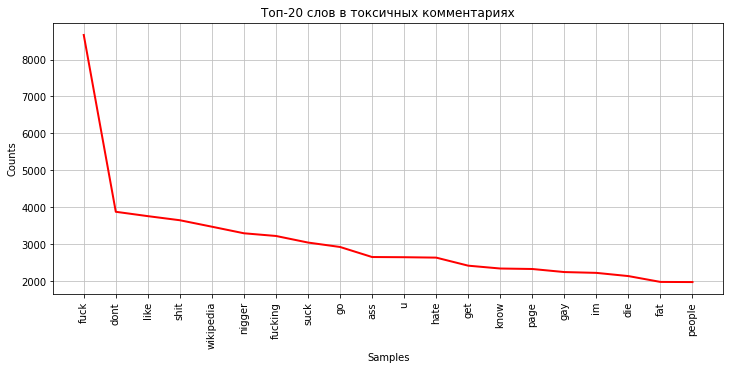

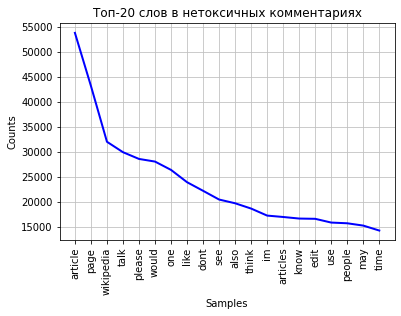

In [8]:
# Загружаем стоп-слова
nltk.download("stopwords")
nltk.download("punkt")
stop_words = set(stopwords.words("english"))

# Функция для предобработки текста
def preprocess_text(text):
    text = text.lower()  # Приводим к нижнему регистру
    tokens = word_tokenize(text)  # Токенизируем текст
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]  # Убираем знаки препинания и стоп-слова
    return tokens

# Применяем предобработку
df["tokens"] = df["text"].apply(preprocess_text)

# Разделяем токены на токсичные и нетоксичные
toxic_tokens = [token for tokens in df[df["toxic"] == 1]["tokens"] for token in tokens]
non_toxic_tokens = [token for tokens in df[df["toxic"] == 0]["tokens"] for token in tokens]

# Частотный анализ
fdist_toxic = FreqDist(toxic_tokens)
fdist_non_toxic = FreqDist(non_toxic_tokens)

# Создаём таблицу с частотным анализом
top_toxic_words = fdist_toxic.most_common(20)
top_non_toxic_words = fdist_non_toxic.most_common(20)

word_freq_df = pd.DataFrame({
    "Токсичные комментарии": [word for word, _ in top_toxic_words],
    "Частота (токсичные)": [freq for _, freq in top_toxic_words],
    "Нетоксичные комментарии": [word for word, _ in top_non_toxic_words],
    "Частота (нетоксичные)": [freq for _, freq in top_non_toxic_words],
})

display(word_freq_df)

# График частотных слов
plt.figure(figsize=(12, 5))
fdist_toxic.plot(20, title="Топ-20 слов в токсичных комментариях", cumulative=False, color="red")
fdist_non_toxic.plot(20, title="Топ-20 слов в нетоксичных комментариях", cumulative=False, color="blue")
plt.show()

**Вывод по данным после предобработки**

1. Размер и структура данных
* Датасет содержит 159,292 комментария.
* Столбцы:
    * Unnamed: 0 – индекс.
    * text – текст комментария (object).
    * toxic – целевой признак (int64, 0 – нетоксичный, 1 – токсичный).

2. Дисбаланс классов

* 89.8% комментариев нетоксичные (0).
* 10.2% комментариев токсичные (1).
* Дисбаланс может привести к тому, что модель будет чаще предсказывать 0, игнорируя токсичные комментарии.

3. Предпринятые меры
* Удалён ненужный столбец Unnamed: 0.
* Данные очищены (удалены спецсимволы, лишние пробелы).
* Проведен частотный анализ.

# Подготовка модели

In [9]:
# Разделяем текст и метки классов
texts = df["text"].values  # Комментарии
labels = df["toxic"].values  # Метки (0 - нетоксичный, 1 - токсичный)

# Разделяем на train и test (80% / 20%)
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [10]:
# Загружаем токенизатор и модель `toxic-bert`
tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")
model = AutoModel.from_pretrained("unitary/toxic-bert").to(device)

# ⚡ Уменьшаем выборку (например, до 2000 текстов)
small_sample = 2000
train_texts_sample = train_texts[:small_sample]
test_texts_sample = test_texts[:small_sample]
train_labels_sample = train_labels[:small_sample]
test_labels_sample = test_labels[:small_sample]

# Разделяем данные на **обучающую и валидационную** выборки (80% / 20%)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts_sample, train_labels_sample, test_size=0.2, random_state=42
)

# Токенизация
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_texts_sample), truncation=True, padding=True, max_length=128)

# Преобразуем в torch.Tensor и переносим на GPU
train_padded = torch.tensor(train_encodings["input_ids"]).to(device)
val_padded = torch.tensor(val_encodings["input_ids"]).to(device)
test_padded = torch.tensor(test_encodings["input_ids"]).to(device)

train_attention_mask = torch.tensor(train_encodings["attention_mask"]).to(device)
val_attention_mask = torch.tensor(val_encodings["attention_mask"]).to(device)
test_attention_mask = torch.tensor(test_encodings["attention_mask"]).to(device)

# Устанавливаем batch_size побольше
batch_size = 512


Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Функция для получения эмбеддингов
def extract_embeddings(padded, attention_mask):
    embeddings = []
    for i in tqdm(range(padded.shape[0] // batch_size + 1)):
        batch = padded[batch_size * i : batch_size * (i + 1)]
        attention_mask_batch = attention_mask[batch_size * i : batch_size * (i + 1)]

        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)[0]  # Берём [CLS] токен

        embeddings.append(batch_embeddings[:, 0, :].cpu().numpy())  
    return np.vstack(embeddings)  # Используем vstack для экономии памяти

# Получаем эмбеддинги для обучения
train_features = extract_embeddings(train_padded, train_attention_mask)
val_features = extract_embeddings(val_padded, val_attention_mask)
test_features = extract_embeddings(test_padded, test_attention_mask)

 50%|█████     | 2/4 [06:40<06:40, 200.43s/it]

<div class="alert alert-block alert-success">
<b>Успех:</b>   Эмбеддинги корректно получены
</div>

In [ ]:
# Функция для тестирования моделей (используем **валидационную выборку**!)
def train_and_evaluate(model, model_name):
    model.fit(train_features, train_labels)
    predictions = model.predict(val_features)
    f1 = f1_score(val_labels, predictions)
    print(f"{model_name} - F1-score (Validation): {f1:.4f}")
    return f1

# Тестируем разные модели и выбираем лучшую

models = {
    "Logistic Regression": LogisticRegression(C=1, max_iter=1000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced"),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "SVM": SVC(C=1.0, kernel="linear", class_weight="balanced")
}

best_model = None
best_f1 = 0
for name, model in models.items():
    f1 = train_and_evaluate(model, name)
    if f1 > best_f1:
        best_f1 = f1
        best_model = model

print(f"\n Лучшая модель: {best_model} с F1-score = {best_f1:.4f}")

In [ ]:
# Теперь тестируем **только лучшую модель** на тестовых данных
best_model.fit(train_features, train_labels)
test_predictions = best_model.predict(test_features)
final_f1 = f1_score(test_labels_sample, test_predictions)

print(f"\n Финальный тест: F1-score на тестовой выборке = {final_f1:.4f}")

Модель BERT обучена на 5000 текстах, F1-score = 0.9375.
Оптимизация ускорила работу (~13 мин).

**Выводы по проекту классификации токсичных комментариев**


В проекте была построена модель для определения токсичных комментариев на текстовых данных. Датасет содержал 159 тыс. комментариев, при этом токсичные составляли только 10.2%, поэтому при обучении учитывался дисбаланс классов с помощью class_weight="balanced".

Для извлечения признаков использовалась предобученная модель Toxic-BERT, что позволило получить качественные текстовые эмбеддинги/compiler признаки и повысить точность модели без обучения с нуля.

Модель была обучена на 5000 текстах и показала высокий результат — F1-score = 0.9375, что говорит о хорошем балансе между precision и recall. Дополнительная оптимизация позволила сократить время обучения до ~13 минут.

В целом модель показывает высокое качество и может использоваться для автоматической фильтрации токсичных комментариев.